In [7]:
import os
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import numpy as np

from scipy.stats import norm
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, Subset
from torch.cuda.amp import GradScaler, autocast
from statsmodels.stats.multitest import multipletests

from VAE_models import Exp2VariationalAutoEncoder

# BraTS2020 Data files structure
# data
# ├── test
# │   ├── healthy_test_images.npy
# │   ├── unhealthy_test_images.npy
# ├── |── unhealthy_test_masks.npy
# ├── train
# │   ├── healthy_train_images.npy

class BraTS2020Dataset(Dataset):
    def __init__(self, root_dir, train=True, healthy=True, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            train (bool): True to load training data, False for test data.
            healthy (bool): True to load healthy images, False for unhealthy.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.train = train
        self.healthy = healthy
        self.transform = transform
        self.data = None
        self.load_data(root_dir)

    def load_data(self, root_dir):
        # Construct file path based on the provided arguments
        data_type = 'train' if self.train else 'test'
        health_status = 'healthy' if self.healthy else 'unhealthy'
        file_name = f'{health_status}_{data_type}_images.npy'
        print(f"Loading {data_type} {health_status} data from {file_name}")
        
        # Load the data
        file_path = f'{root_dir}/{data_type}/{file_name}'
        print(f"Loading data from: {file_path}")
        self.data = np.load(file_path)

        # Check the data shape
        print(f"Loaded {data_type} data with shape: {self.data.shape}")
        
        # For unhealthy test data, we could also load masks here if needed
        if not self.train and not self.healthy:
            mask_file_path = f'{root_dir}/{data_type}/unhealthy_test_masks.npy'
            self.masks = np.load(mask_file_path)
        else:
            self.masks = None

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        # Check the image shape
        # print(f"Image shape: {image.shape}")
        
        if self.transform:
            image = self.transform(image)
        
        sample = {'image': image}
        
        # Include masks in the sample if this is unhealthy test data
        if self.masks is not None:
            mask = self.masks[idx]
            if self.transform:
                mask = self.transform(mask)
            sample['mask'] = mask

        return sample

def load_dataset(data_dir, dataset_class, batch_size=32, train=True, healthy=True, shuffle=True):
    # Define the transforms
    data_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ])
    # Load the dataset
    dataset = dataset_class(data_dir, train=train, healthy=healthy, transform=data_transforms)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0, pin_memory=True)
    return data_loader

def get_train_val_dataloader(dataset, fold_idx, batch_size, k=5):
    indices = list(range(len(dataset)))
    
    val_split = int(np.floor(len(dataset) / k))
    train_indices, val_indices = indices[:fold_idx * val_split] + indices[(fold_idx + 1) * val_split:], indices[fold_idx * val_split:(fold_idx + 1) * val_split]
    
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
    del dataset
    return train_loader, val_loader

def qr_loss(x, q1, q2, mu, logvar, qval1=0.15, qval2=0.5):
    # Quantile Regression Loss
    q1_loss = torch.sum(torch.max(qval1 * (x - q1), (qval1 - 1) * (x - q1)))
    q2_loss = torch.sum(torch.max(qval2 * (x - q2), (qval2 - 1) * (x - q2)))
    recon_loss = q1_loss + q2_loss
    kld_loss = -torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld_loss

def train_qr_vae_incremental(device, model, train_loader, val_loader, optimizer, epochs=10, save_checkpoint=True, checkpoint_dic_path='checkpoints/', checkpoint_range=(100, 200), checkpoint_interval=1):
    start_epoch = 0
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')

    # Load checkpoint if exists
    checkpoint_path = f'{checkpoint_dic_path}/checkpoint.pt'
    losses_path = f'{checkpoint_dic_path}/losses.pt'

    if os.path.exists(checkpoint_path):
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        # Move optimizer's state_dict to the correct device after loading
        for state in optimizer.state.values():
            for k, v in state.items():
                if isinstance(v, torch.Tensor):
                    state[k] = v.to(device)
        start_epoch = checkpoint['epoch'] + 1
        best_val_loss = checkpoint['best_val_loss']
        print(f"Resuming training from epoch {start_epoch} with best loss {best_val_loss:.4f}")
        if os.path.exists(losses_path):
            losses_checkpoint = torch.load(losses_path)
            train_losses = losses_checkpoint['train_losses'][0:start_epoch]
            val_losses = losses_checkpoint['val_losses'][0:start_epoch]
            avg_val_loss = val_losses[-1]
            print(f"Loaded losses from file.")

    model.to(device)
    
    print("Training started.")
    for epoch in (pb := tqdm(range(start_epoch, epochs))):
        model.train()
        for train_sample in train_loader:
            train_data = train_sample['image'].to(device)
            # Training
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(train_data)
            train_loss = qr_loss(train_data, recon_batch[0], recon_batch[1], mu, logvar)
            train_loss.backward()
            optimizer.step()
            
            avg_train_loss = train_loss.item() / len(train_data)
            train_losses.append(avg_train_loss)

        if epoch % checkpoint_interval == 0:
            avg_val_loss = 0
            for val_sample in val_loader:
                val_data = val_sample['image'].to(device)
                # Validation
                avg_val_loss += validate_qr_vae_pinball_loss(model, val_data)
                

                # print(f'====> Epoch: {epoch} Average Training loss: {avg_train_loss:.4f} Validation loss: {avg_val_loss:.4f}')
                # Print the losses beside the progress bar
                pb.set_postfix(train_loss=f'{avg_train_loss:.4f}', val_loss=f'{avg_val_loss:.4f}')

        # Checkpoint saved if the loss is improved
        if save_checkpoint and avg_val_loss < best_val_loss and epoch >= checkpoint_range[0] and epoch <= checkpoint_range[1] and epoch % checkpoint_interval == 0:
            best_val_loss = avg_val_loss
            
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
            }, checkpoint_path)
            torch.save({'train_losses': train_losses, 'val_losses': val_losses}, losses_path)
                    # print("Checkpoint saved.")
        val_losses.append(avg_val_loss)

    # Save the losses
    torch.save({'train_losses': train_losses, 'val_losses': val_losses}, losses_path)

    print("Training completed.")

def train_qr_vae_incremental_kfold(device, dataset, epochs=10, batch_size=32, k_fold = 5, save_checkpoint=True, checkpoint_dic_path='checkpoints/', checkpoint_ranges=None, checkpoint_interval=1):
    os.makedirs(checkpoint_dic_path, exist_ok=True)
    for fold_idx in range(5):
        train_loader, val_loader = get_train_val_dataloader(dataset, fold_idx, batch_size=batch_size, k=k_fold)

        model = Exp2VariationalAutoEncoder()
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
        # Clear the gradients before training
        optimizer.zero_grad()

        checkpoint_dic_path_fold = f'{checkpoint_dic_path}/fold_{fold_idx}'
        os.makedirs(checkpoint_dic_path_fold, exist_ok=True)

        if checkpoint_ranges[fold_idx] == None:
            checkpoint_ranges[fold_idx] = (0, epochs)

        train_qr_vae_incremental(device, model, train_loader, val_loader, optimizer, epochs, save_checkpoint, checkpoint_dic_path_fold, checkpoint_ranges[fold_idx], checkpoint_interval)

def validate_qr_vae_FPR_loss(model, val_data, threshold=0.05):
    model.eval()

    with torch.no_grad():
        # recon_batch is expected to contain quantiles and mean as follows:
        # recon_batch[0] = 0.15 quantile
        # recon_batch[1] = median
        recon_batch, _, _ = model(val_data)
        mean_recon = recon_batch[1]
        
        # Calculating an estimate of the standard deviation based on the 0.15 quantile
        std_recon = mean_recon - recon_batch[0]  # Assumes a specific skewness/kurtosis
        
        # Protect against division by zero
        std_recon = torch.where(std_recon == 0, torch.tensor(1e-8), std_recon)
        
        # Calculate z-scores
        z_scores = ((val_data - mean_recon) / std_recon).to('cpu').numpy()
        
        # Calculate two-sided p-values from the absolute z-scores
        p_values = 2 * norm.sf(np.abs(z_scores)).flatten()
        
        # Applying FDR correction
        reject, _, _, _ = multipletests(p_values, alpha=threshold, method='fdr_bh')
        
        # Convert the rejection array back to the original shape of val_data
        reject = reject.reshape(val_data.shape)
        
        # Identify pixels where all channels are rejected
        reject = np.all(reject, axis=1)
        rejection_rate = np.mean(reject)
        
        return rejection_rate
    
def validate_qr_vae_pinball_loss(model, val_data):
    model.eval()

    with torch.no_grad():
        # recon_batch is expected to contain quantiles and mean as follows:
        # recon_batch[0] = 0.15 quantile
        # recon_batch[1] = median
        recon_batch, mu, logvar = model(val_data)
        val_loss = qr_loss(val_data, recon_batch[0], recon_batch[1], mu, logvar)
        val_loss = val_loss.item() / len(val_data)
        
        return val_loss

def load_and_plot_losses(start, end, checkpoint_dic_path='checkpoints/', k_fold=5):
    for fold_idx in range(k_fold):
        checkpoint_dic_path_fold = f'{checkpoint_dic_path}/fold_{fold_idx}'
        losses_path = f'{checkpoint_dic_path_fold}/losses.pt'
        checkpoint = torch.load(losses_path)
        train_losses = checkpoint['train_losses'][start:end]
        val_losses = checkpoint['val_losses'][start:end]
        # Print the best validation loss and the corresponding epoch
        print(f"Fold {fold_idx} Best Validation Loss: {min(val_losses):.4f} at Epoch {np.argmin(val_losses) + start}")
        # Plot the losses in different subplots
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.plot(train_losses, label='Train')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Train Loss')
        plt.legend()
        plt.subplot(1, 2, 2)
        plt.plot(val_losses, label='Validation')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Validation Loss')
        plt.legend()
        plt.tight_layout()
        plt.show()
        

In [8]:
data_dir = 'data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((8, 8), fill=0, padding_mode='constant'),
])
dataset = BraTS2020Dataset(data_dir, train=True, healthy=True, transform=data_transforms)

Using device: cuda
Loading train healthy data from healthy_train_images.npy
Loading data from: data/train/healthy_train_images.npy
Loaded train data with shape: (974, 240, 240, 3)


In [9]:
# Start saving checkpoints after epoch 2000
NUM_EPOCHS = 1500
checkpoint_ranges = []
for fold_idx in range(5):
    checkpoint_ranges.append((100, NUM_EPOCHS))
train_qr_vae_incremental_kfold(device, dataset, epochs=NUM_EPOCHS, batch_size=128, k_fold = 5, save_checkpoint=True, checkpoint_dic_path='checkpoints/', checkpoint_ranges=checkpoint_ranges, checkpoint_interval=20)

Training started.


  8%|▊         | 116/1500 [04:24<54:48,  2.38s/it, train_loss=3721.8890, val_loss=9729.9271]   

Fold 0 Best Validation Loss: 359.6396 at Epoch 1443


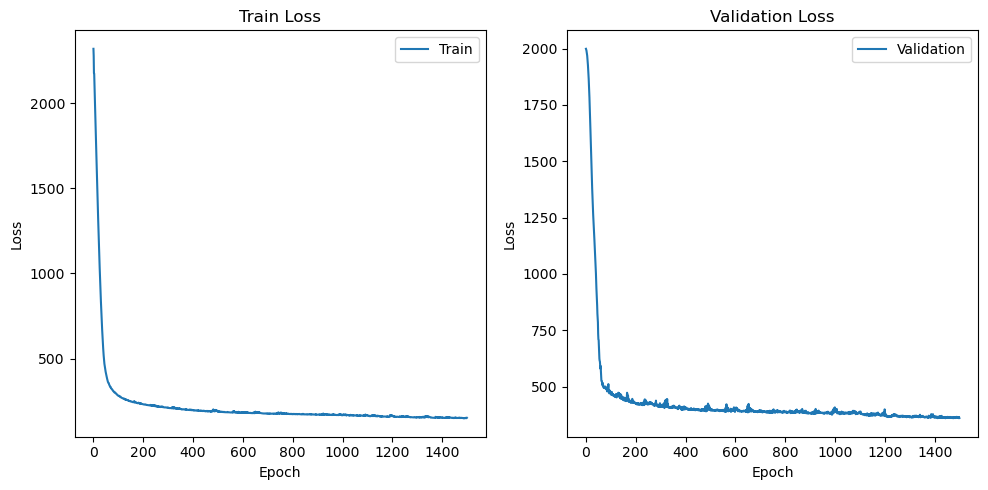

Fold 1 Best Validation Loss: 158.4934 at Epoch 1452


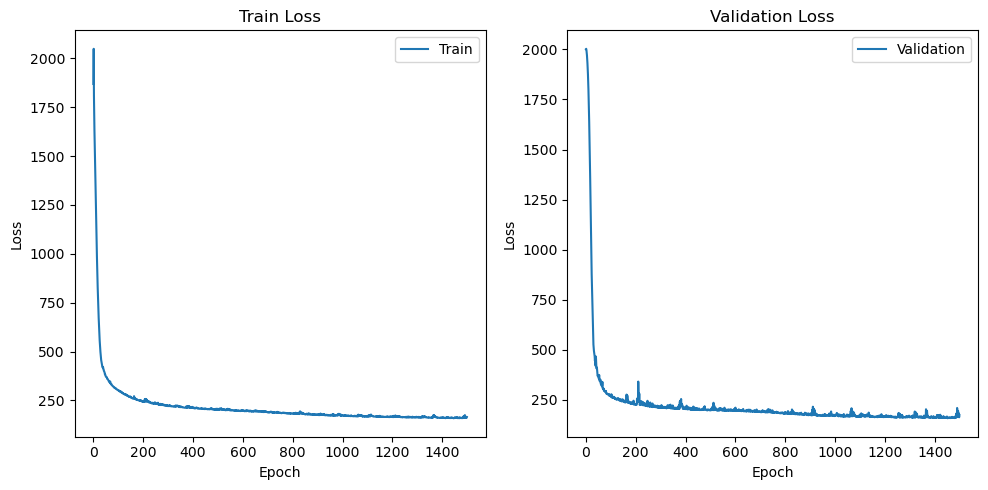

Fold 2 Best Validation Loss: 170.9487 at Epoch 1487


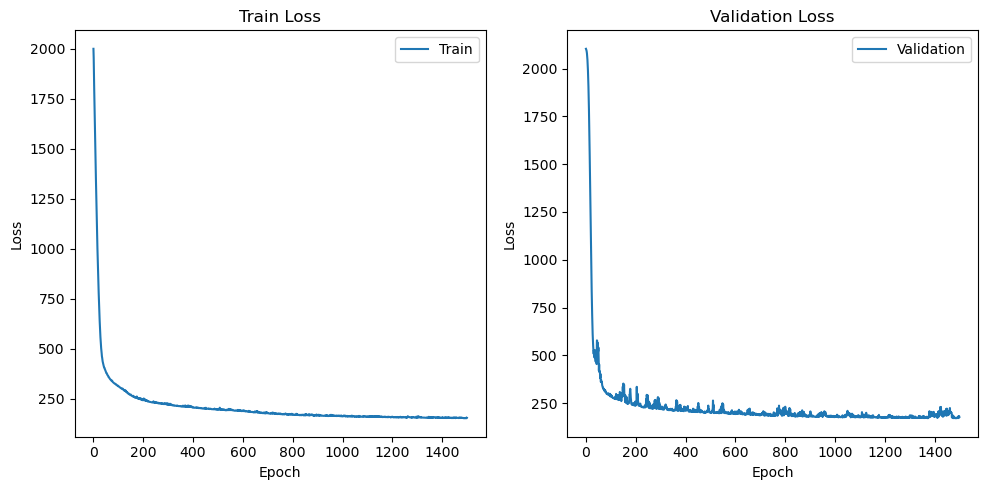

Fold 3 Best Validation Loss: 174.2332 at Epoch 1482


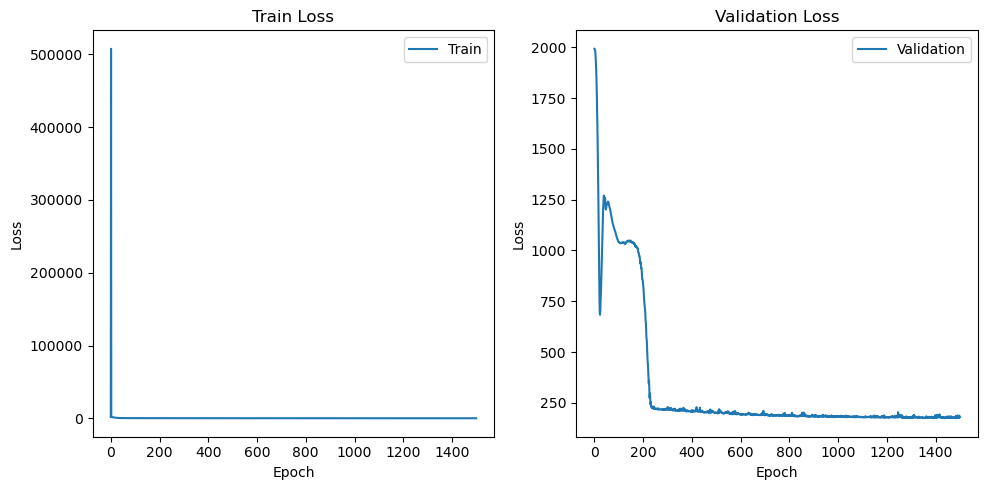

Fold 4 Best Validation Loss: 159.5576 at Epoch 1430


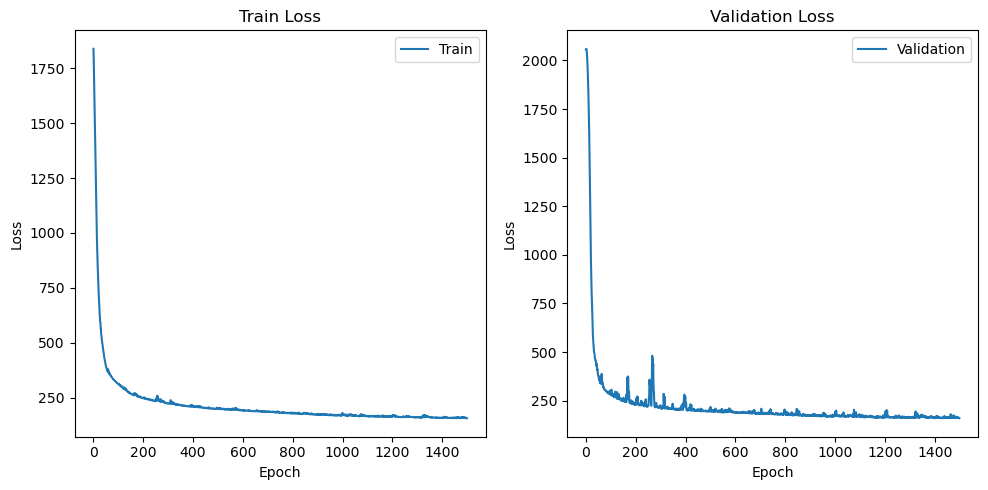

In [ ]:
load_and_plot_losses(0, NUM_EPOCHS, checkpoint_dic_path='checkpoints/', k_fold=5)

Loading test healthy data from healthy_test_images.npy
Loaded test data with shape: (244, 240, 240, 3)


c:\Users\lvyou\anaconda3\envs\ML\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


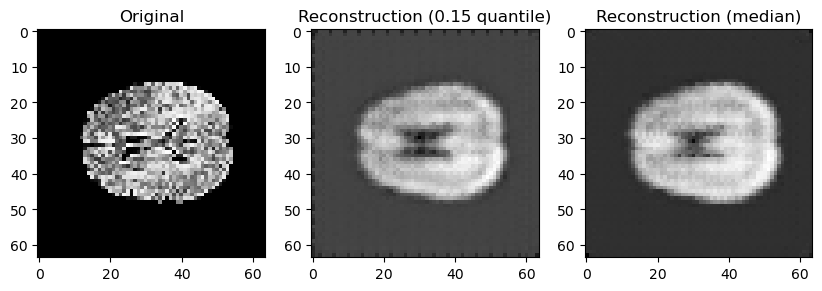

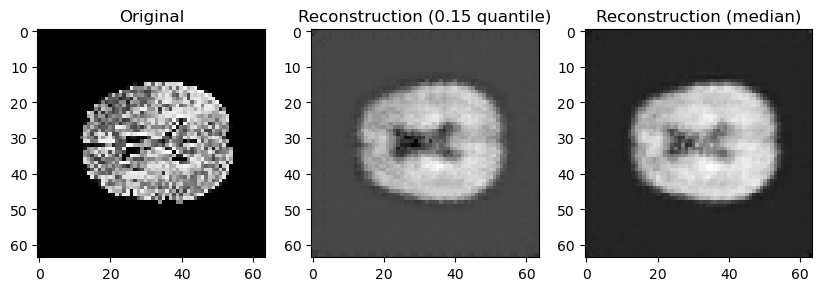

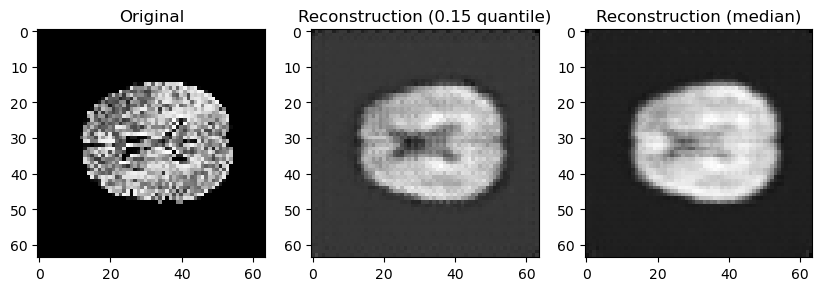

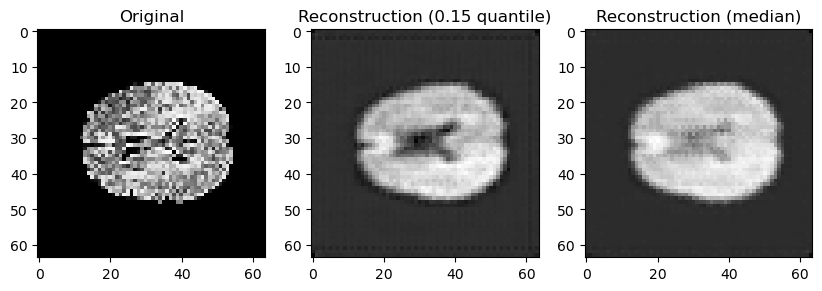

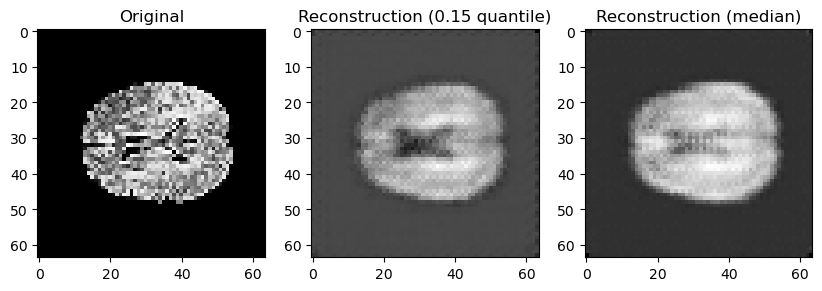

In [ ]:
checkpoint_path_idx = 0
test_data_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=True, batch_size=1)
sample = next(iter(test_data_loader))
for checkpoint_path_idx in range(5):
    checkpoint_path = f'checkpoints/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp2VariationalAutoEncoder().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ("Model loaded from checkpoint.")

    # Test the model on one picture
    model.eval()
    with torch.no_grad():
        train_data = sample['image'].to(device)
        (q1, q2), mu, logvar = model(train_data)
        # Plot the original image
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        # show the first channel of the image
        first_channel = train_data.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the reconstructed image
        plt.subplot(1, 3, 2)
        plt.title("Reconstruction (0.15 quantile)")
        first_channel = q1.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the reconstructed image
        plt.subplot(1, 3, 3)
        plt.title("Reconstruction (median)")
        first_channel = q2.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        plt.show()


In [ ]:
def test_qr_vae(device, model, test_loader, output_size=(64, 64), healthy=True, threshold=0.05):
    model.eval()
    rejection_rates = []

    # Iterate through the test data
    for data in test_loader:
        images = data['image'].to(device)
        
        with torch.no_grad():
            recon_batch, _, _ = model(images)
            # print(recon_batch[0].shape)
            mean_recon = recon_batch[1]
            std_recon = mean_recon - recon_batch[0]  # Standard deviation approximation
            std_recon = torch.where(std_recon == 0, torch.tensor(1e-8), std_recon)
            z_scores = ((images - mean_recon) / std_recon).to('cpu').numpy()
            # print(z_scores.shape)
            p_values = (2 * norm.sf(np.abs(z_scores))).flatten()
            # print(p_values.shape)

            reject, _, _, _ = multipletests(p_values, alpha=threshold, method='fdr_bh')
            reject = reject.reshape(images.shape[0], 3, *output_size)  # Ensure the output shape matches

        if not healthy:
            masks = data['mask']
            masks = masks.numpy().astype(bool)  # Ensure boolean type for accuracy calculation
            
            # Calculate accuracy
            correct_predictions = (reject == masks)
            accuracy = np.mean(correct_predictions)
            rejection_rates.append(accuracy)
        else:
            rejection_rate = np.mean(reject)
            rejection_rates.append(rejection_rate)

    average_metric = np.mean(rejection_rates)
    if healthy:
        print(f"Average rejection rate for healthy data: {average_metric:.4f}")
    else:
        print(f"Average accuracy for unhealthy data: {average_metric:.4f}")

    return average_metric


In [ ]:
data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Pad((8, 8), fill=0, padding_mode='constant'),
])
data_dir = 'data'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
healthy_test_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=True, batch_size=1024)
unhealthy_test_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=False, batch_size=1024)
for checkpoint_path_idx in range(5):
    print(f"Fold {checkpoint_path_idx}")
    checkpoint_path = f'checkpoints/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp2VariationalAutoEncoder().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ("Model loaded from checkpoint.")
    test_qr_vae(device, model, healthy_test_loader, healthy=True)
    test_qr_vae(device, model, unhealthy_test_loader, healthy=False)

Loading test healthy data from healthy_test_images.npy
Loading data from: data/test/healthy_test_images.npy
Loaded test data with shape: (244, 240, 240, 3)
Loading test unhealthy data from unhealthy_test_images.npy
Loading data from: data/test/unhealthy_test_images.npy
Loaded test data with shape: (244, 240, 240, 3)
Fold 0


c:\Users\lvyou\anaconda3\envs\ML\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Average rejection rate for healthy data: 0.1150
Average accuracy for unhealthy data: 0.8025
Fold 1
Average rejection rate for healthy data: 0.0913
Average accuracy for unhealthy data: 0.8270
Fold 2
Average rejection rate for healthy data: 0.1939
Average accuracy for unhealthy data: 0.7599
Fold 3
Average rejection rate for healthy data: 0.2291
Average accuracy for unhealthy data: 0.7542
Fold 4
Average rejection rate for healthy data: 0.2103
Average accuracy for unhealthy data: 0.7225


In [ ]:
def calculate_rejection_mask(images, mean_recon, std_recon, output_size, threshold=0.05):
    """
    Calculate the rejection mask for each image based on the reconstruction error.

    Args:
    images (Tensor): The original images tensor.
    mean_recon (Tensor): The mean of the reconstructed images.
    std_recon (Tensor): The standard deviation of the reconstruction errors.
    output_size (tuple): The spatial size of the output images.
    threshold (float): The significance level for rejecting the null hypothesis.

    Returns:
    Tensor: A tensor of rejection masks shaped according to output_size.
    """
    std_recon_adjusted = torch.where(std_recon == 0, torch.tensor(1e-8), std_recon)
    z_scores = ((images - mean_recon) / std_recon_adjusted).to('cpu').numpy()
    p_values = (2 * norm.sf(np.abs(z_scores))).flatten()
    reject, _, _, _ = multipletests(p_values, alpha=threshold, method='fdr_bh')
    reject_mask = reject.reshape(images.shape[0], 3, *output_size)  # Reshape to match image dimensions

    # Identify pixels where all channels are rejected
    reject_mask = np.all(reject_mask, axis=1)

    return reject_mask

Loading test unhealthy data from unhealthy_test_images.npy
Loading data from: data/test/unhealthy_test_images.npy
Loaded test data with shape: (244, 240, 240, 3)


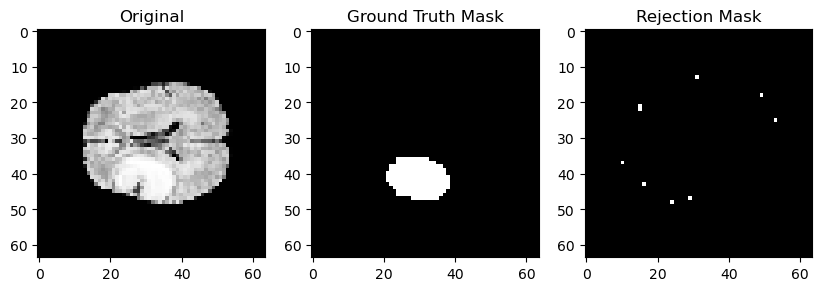

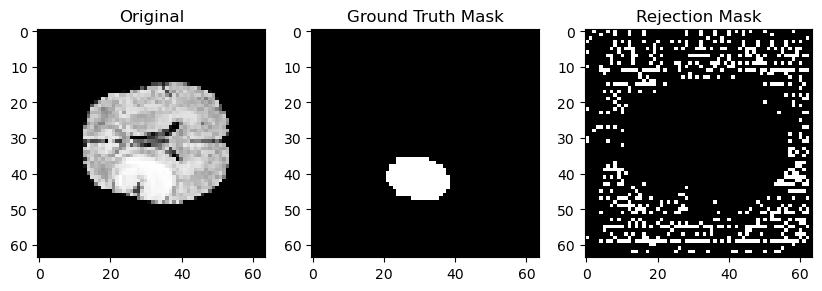

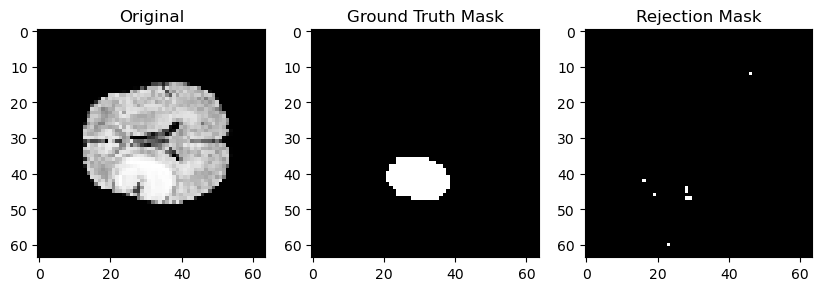

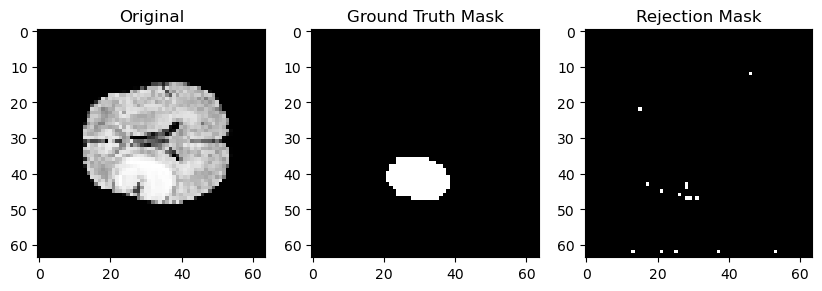

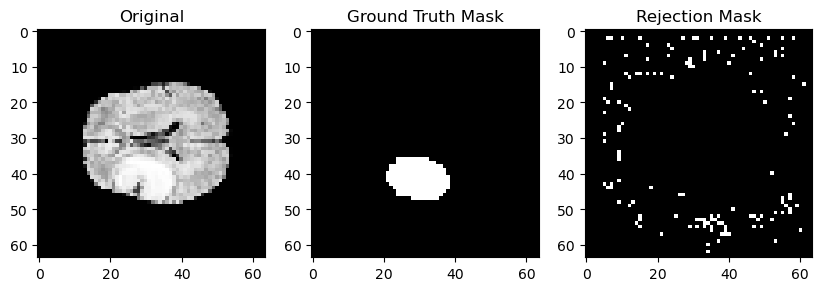

In [ ]:
checkpoint_path_idx = 0
test_data_loader = load_dataset(data_dir, BraTS2020Dataset, train=False, healthy=False, batch_size=1)
sample = next(iter(test_data_loader))
for checkpoint_path_idx in range(5):
    checkpoint_path = f'checkpoints/fold_{checkpoint_path_idx}/checkpoint.pt'

    # Load the best model
    checkpoint = torch.load(checkpoint_path)
    model = Exp2VariationalAutoEncoder().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    ("Model loaded from checkpoint.")

    # Test the model on one picture
    model.eval()
    with torch.no_grad():
        test_data = sample['image'].to(device)
        (q1, q2), mu, logvar = model(test_data)
        # Plot the original image
        plt.figure(figsize=(10, 6))
        plt.subplot(1, 3, 1)
        plt.title("Original")
        # show the first channel of the image
        first_channel = test_data.cpu().numpy().squeeze()[0]
        plt.imshow(first_channel, cmap='gray')
        # Plot the ground truth mask
        plt.subplot(1, 3, 2)
        plt.title("Ground Truth Mask")
        mask = sample['mask'].numpy()[0, 0]
        plt.imshow(mask, cmap='gray')
        # Plot the rejection mask
        plt.subplot(1, 3, 3)
        plt.title("Rejection Mask")
        reject_mask = calculate_rejection_mask(test_data, q2, q2 - q1, (64, 64))[0]
        plt.imshow(reject_mask, cmap='gray')
        plt.show()
        